In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

import plotTools as pt

plt.rcParams.update({"text.usetex": True,"font.family": "serif"})

In [2]:
jobNameBias = 'fisher_baryon_bias'

pythonFlag = 3

fishersBias, cosmoParamsBias = pt.loadGaussianNG(jobName = jobNameBias, pythonFlag = pythonFlag, \
                                               returnCosmoParams = True)
biasVectorsBias = pt.loadBiasVectors(jobName = jobNameBias, pythonFlag = pythonFlag, \
                                   returnCosmoParams = False)

In [3]:
fsky = 0.5

fishersBias = pt.addfsky(fishersBias, fsky)
biasVectorsBias = pt.addfsky(biasVectorsBias, fsky)

fishersBias_tau = pt.addTau(fishersBias, cosmoParamsBias)

sTypes = ['lensed','delensed','unlensed']
gTypes = ['NonGaussian','Gaussian']
paramsToFix = ['mnu']
for i in range(2):
    for gt, gaussianType in enumerate(gTypes):
        for st, spectrumType in enumerate(sTypes):
            fisher = fishersBias_tau[gaussianType][spectrumType][i]
            fishersBias_tau[gaussianType][spectrumType][i] = pt.fixParameters(fisher = fisher, \
                                                                        cosmoParams = cosmoParamsBias, \
                                                                        paramsToFix = paramsToFix, \
                                                                        returnFixedParamList = False)
            bias = biasVectorsBias[gaussianType][spectrumType][i]
            biasVectorsBias[gaussianType][spectrumType][i], cosmoParamsBias_fixed = pt.fixParameters(fisher = bias, \
                                                                            cosmoParams = cosmoParamsBias, \
                                                                            paramsToFix = paramsToFix, \
                                                                            returnFixedParamList = True)

covMatsBias = pt.invertFishers(fishersBias_tau, sTypes = sTypes)
            
sigmasBias = pt.getSigmas(covMatsBias, sTypes = sTypes)
biasesBias = pt.getBiases(covMatsBias, biasVectorsBias, sTypes = sTypes)

In [4]:
cosmoFid = {'omega_c_h2':0.1197, \
                'omega_b_h2': 0.0222, \
                'N_eff': 3.046, \
                'A_s' : 2.196e-9, \
                'n_s' : 0.9655,\
                'tau' : 0.06, \
                'H0' : 67.5, \
                'theta_s' : 0.010409, \
                #'Yhe' : 0.25, \
                #'r'   : 0.01, \
                'mnu' : 0.06, \
                'eta_0' : 0.603, \
                'c_min' : 3.13}

cosmoParamsPretty = {'omega_c_h2' : '$\Omega_ch^2$', \
                    'omega_b_h2' :    '$\Omega_bh^2$', \
                    'N_eff':   '$N_\mathrm{eff}$', \
                    'A_s' :  '$A_s$', \
                    'n_s' : '$n_s$', \
                    'tau' :  r'$\tau$', \
                    'theta_s': r'$\theta_s$', \
                    'mnu' : r'$M_\nu$', \
                    'Yhe' : r'$Y_{He}$', \
                    'r': '$r$', \
                    'eta_0': '$\eta_0$', \
                    'c_min': '$c_{min}$', \
                    'H0': '$H_0$'}

from matplotlib.lines import Line2D

In [5]:
def getContour(covOneOne, covTwoTwo, covOneTwo, paramOneFid, paramTwoFid, width = 2, num = 100):

    levels = [2.3]
    cov = np.array([[covOneOne, covOneTwo], [covOneTwo, covTwoTwo] ])
    invcov = np.linalg.inv(cov)

    x = np.linspace(paramOneFid - width * np.sqrt(cov[0,0]), \
                        paramOneFid + width * np.sqrt(cov[0,0]), num)
    y = np.linspace(paramTwoFid - width * np.sqrt(cov[1,1]), \
                        paramTwoFid + width * np.sqrt(cov[1,1]),  num)

    xx, yy = np.meshgrid(x, y)

    func = invcov[0,0] * (xx - paramOneFid)**2 \
        +  invcov[1,1] * (yy - paramTwoFid)**2 \
        + 2 * invcov[0,1] * (xx - paramOneFid) * (yy - paramTwoFid)

    return xx, yy, func

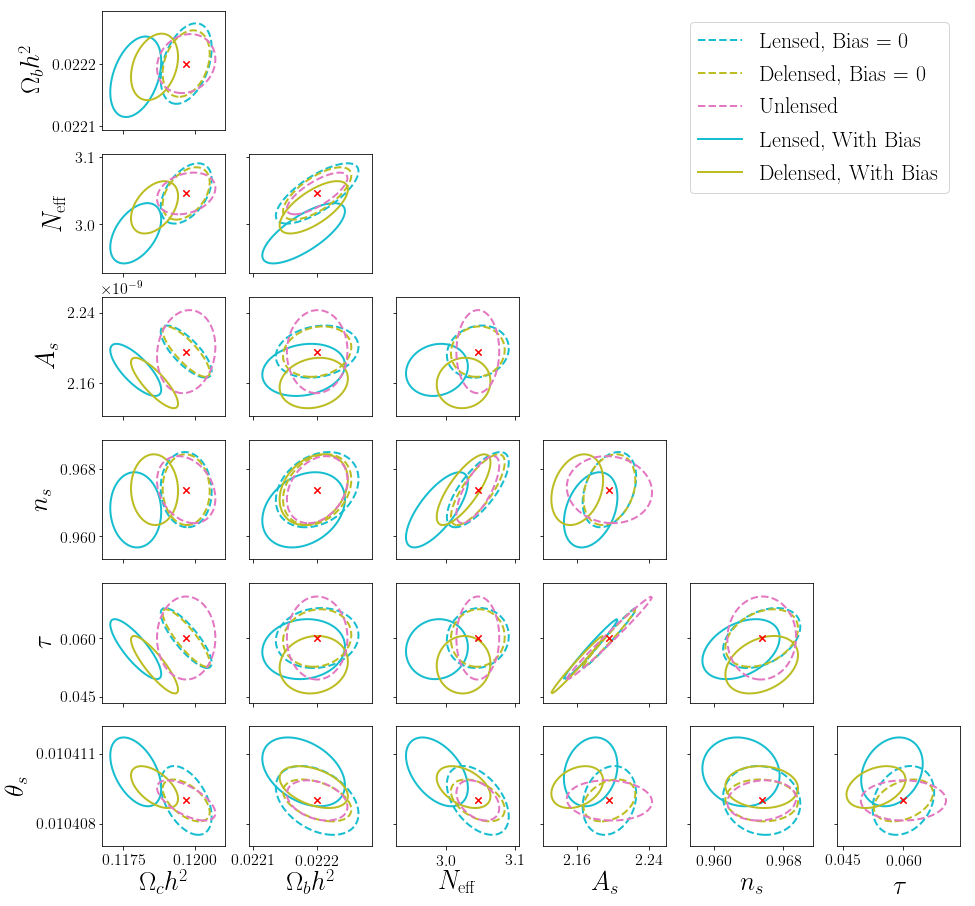

In [6]:
cosmoParamsEllipses = cosmoParamsBias_fixed

fig = plt.figure('fisher ellipses', figsize = (18,18))
plt.clf()
nPlots = len(cosmoParamsEllipses)

eiEllipses = 0
expNames = range(2)
exp = expNames[eiEllipses]
colors = ['C9', 'C8', 'C6']
linestyles = ['-', '--']

fs=10

for cp1, cosmo1 in enumerate(cosmoParamsEllipses):
    for cp2, cosmo2 in enumerate(cosmoParamsEllipses):
        if (cp1 < cp2):
            ax = plt.subplot(nPlots, nPlots, nPlots * cp2 + cp1 + 1 )
            for st, spectrumType in enumerate(['lensed','delensed','unlensed']):
                for gt, gaussType in enumerate(['NonGaussian']):
                    fi = covMatsBias[gaussType][spectrumType][exp]
                    bi = biasesBias[gaussType][spectrumType][exp]

                    paramOneInd = cosmoParamsEllipses.index(cosmo1)
                    paramTwoInd = cosmoParamsEllipses.index(cosmo2)
    
                    xx, yy, contourToPlot = getContour(fi[paramOneInd, paramOneInd], \
                                                                    fi[paramTwoInd, paramTwoInd], \
                                                                    fi[paramOneInd, paramTwoInd], \
                                                                    cosmoFid[cosmo1], \
                                                                    cosmoFid[cosmo2])
                    plt.plot(cosmoFid[cosmo1],cosmoFid[cosmo2],color='r',marker='x')
                    
                    if spectrumType=='unlensed':
                        CSB = plt.contour(xx+bi[cp1], yy+bi[cp2], contourToPlot, levels = [2.3], linestyles = [linestyles[1]], linewidths = 2, \
                                    colors = [colors[st]])
                    else:
                        CS1 = plt.contour(xx, yy, contourToPlot, levels = [2.3], linestyles = [linestyles[1]], linewidths = 2, \
                                    colors = [colors[st]])

                        CSB = plt.contour(xx+bi[cp1], yy+bi[cp2], contourToPlot, levels = [2.3], linestyles = [linestyles[0]], linewidths = 2, \
                                    colors = [colors[st]])

                    if cp2 == nPlots-1:
                        plt.xlabel(cosmoParamsPretty[cosmo1], fontsize = 16+fs)
                        plt.xticks(fontsize=6+fs)
                        if cosmo1 == 'A_s' and cosmo2 == 'H0' and st == 0 and gt == 0:
                            ax.get_xaxis().get_offset_text().set_visible(False)
                            ax_max = max(ax.get_xticks())
                            exponent_axis = np.floor(np.log10(ax_max)).astype(int)
                            ax.annotate(r'$\times$10$^{%i}$'%(exponent_axis),
                                         xy=(.64, .02), xycoords='axes fraction', fontsize=6+fs)
                        else:
                            ax.get_xaxis().get_offset_text().set_visible(False)
                    else:
                        plt.gca().xaxis.set_ticklabels([])
                    if cp1 == 0:
                        plt.ylabel(cosmoParamsPretty[cosmo2], fontsize = 16+fs)
                        plt.yticks(fontsize=6+fs)
                        ax.yaxis.offsetText.set_fontsize(6+fs)
                    else:
                        plt.gca().yaxis.set_ticklabels([])
                    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
                    ax.yaxis.set_major_locator(plt.MaxNLocator(2))
                    
custom_lines = [Line2D([0], [0], ls=linestyles[1], color=colors[0], lw=2),
                Line2D([0], [0], ls=linestyles[1], color=colors[1], lw=2),
                Line2D([0], [0], ls=linestyles[1], color=colors[2], lw=2),
                Line2D([0], [0], ls=linestyles[0], color=colors[0], lw=2),
                Line2D([0], [0], ls=linestyles[0], color=colors[1], lw=2)]
ax = plt.subplot(nPlots, nPlots, nPlots+nPlots-1)
ax.axis("off")
ax.legend(custom_lines, ['Lensed, Bias = 0', 'Delensed, Bias = 0', 'Unlensed', \
                         'Lensed, With Bias', 'Delensed, With Bias'], fontsize=12+fs)

plt.savefig('fig_baryonbias.pdf', bbox_inches = 'tight')